In [13]:
test=np.load('FS-cell_seizure_CONFIG1_fit.npy')

In [1]:
import numpy as np
import sys
sys.path.append('../')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt

from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [2]:
def deriv1(funct,v,numb_var,h):

    first_deriv=[]
    #vsec_plus=np.ones(numb_var)
    #vsec_minus=np.ones(numb_var)
    
    #for i in range(numb_var+numb_adapt): # initialization of perturbation vector
    vsec_plus=v.copy()
    vsec_minus=v.copy()
    
    for i in range(numb_var):
        vsec_plus[i]+=0.5*h # perturb one component
        vsec_minus[i]-=0.5*h
        first_deriv.append((funct(*vsec_plus)-funct(*vsec_minus))/h)
        vsec_plus[i]=v[i] # reset component
        vsec_minus[i]=v[i]
        
    return first_deriv

def deriv2(funct,v,numb_var,h):  
    # separate first and second deriv to avoid useless confusion
    sec_deriv=[]
    #vsec_plus=np.ones(numb_var)
    #vsec_minus=np.ones(numb_var)
    #first_deriv=deriv1(funct,v,numb_var,h)
    
    #for i in range(numb_var+numb_adapt): # initialization of perturbation vector
    vsec_plus=v.copy()
    vsec_minus=v.copy()
        
    for i in range(numb_var):
        deriv_2_temp=[]
        for j in range(numb_var):
            vsec_plus[j]+=0.5*h # perturb one component
            vsec_minus[j]-=0.5*h    
            deriv_2_temp.append((deriv1(funct,vsec_plus,numb_var,h)[i]-\
                                 deriv1(funct,vsec_minus,numb_var,h)[i])/h)
            vsec_plus[j]=v[j] # reset component
            vsec_minus[j]=v[j]
        
        sec_deriv.append(deriv_2_temp)
        
    return sec_deriv

In [157]:
def rk4_withstep(x0,params,time):

    p=params[1]# // variables needed to build arrays
    #int lp = par[8];
    dx=np.zeros(p)  
    deriv=np.zeros(p)
    xt = np.zeros(p)

    for i in range(p):
        dx[i]=deriv[i]=xt[i]=0
    
    deriv=MeanField_Split(x0, params, time)

    for i in range(p): 
        dx[i]=deriv[i] # x[i]=k1[i]
        xt[i]=x0[i]+0.5*deriv[i]*params[0] # argument for k2 (careful k1,2,3,4 in comment = k's of RK method, different from k1 & k2 of the code)

    time+=params[0]/2;

    deriv=MeanField_Split(xt, params, time)
    
    for i in range(p):
        dx[i]+=2*deriv[i] # x[i]=k1[i]+2*k2[i]
        xt[i]=x0[i]+0.5*deriv[i]*params[0] # argument for k3	


    deriv=MeanField_Split(xt, params, time)


    for i in range(p):
        dx[i]+=2*deriv[i] 
        xt[i]=x0[i]+deriv[i]*params[0] # //argument for k4

    time+=params[0]/2;

    deriv=MeanField_Split(xt, params, time)


    for i in range(p):
        dx[i]+=deriv[i] # x[i]=k1[i]+2*k2[i]
        xt[i]=x0[i]+deriv[i]*params[0] 


    for i in range(p):
        x0[i]=x0[i]+dx[i]*params[0]/6.0
        
        
        
def Euler_method_withstep(x0,params,time):
    
    p=params[1]
    deriv=MeanField_dynamics_manual(x0, time)
   # print('deriv = ', deriv)
    for i in range(p): 
        x0[i]+=deriv[i]*params[0]

    time+=params[0]

   
        

In [156]:
def MeanField_Split(x0,params,t):
    #print(' t = ',t)
    tstep=params[0]
    tauw=params[2]
    a=params[3]
    b=params[4]
    El=params[5]
    N=params[6]
    numb_var=params[7]
    numb_adapt=params[8]
    F=params[9]
    h=params[10]
    T=params[11]
    mu=params[20]
    ext_drive=params[21]
    v=[]
    c=[]
    w=[]
   # vsec_vec=[]
    
    testtau=tauw[0]
    testb=b[0]
    testa=a[0]
    testmu=mu[0]
    testEl=El[0]
    index=0
    
    vsec_vec=np.zeros((numb_var,numb_var+1)) # Needed to pass different values to TF1 and TF2
    ''' Reshape the variables for more clarity '''
    
    for i in range(numb_var):
        v.append(x0[i])
        
        c_temp=[]
        for j in range(numb_var):
            c_temp.append(x0[index+numb_var])
            index+=1
            vsec_vec[i][j]=x0[j]
        c.append(c_temp)
        
    index=0 # rester index   
    
    for k in range(numb_adapt):
        w.append(x0[numb_var*numb_var+numb_var+index])
        for i in range(numb_var):
            if (i<numb_adapt): vsec_vec[i][numb_var]=x0[numb_var*numb_var+numb_var+index]
                #else: vsec_vec[i][numb_var]=0
        index+=1
    
    testw=w[0]
    

                   
    #A = A_function(N,vsec,T,numb_var)
        
    #v_exc=(v[0]+v[1])/2+10.+input_rate(t,2,0.1,0.3,5)
    
   # vsec=v[0]+10.#+input_rate(t,0.5,0.05,0.2,5)
    #vsec_vec=x0.copy() # for the derivatives
    
    for i in range(numb_var):
        vsec_vec[i][0]+=ext_drive+input_rate(t, 2., 0.1, 0.1, 120, 1) #+input_rate(t,0.1,0.005,0.02,10)
    
    dv=np.zeros(numb_var)
    dc=np.zeros((numb_var,numb_var))
    dw=np.zeros(numb_adapt)
    
    # Define the derivatives here to compute them only once #
    
    Delta1=np.zeros((numb_var,numb_var))
    Delta2=np.zeros((numb_var,numb_var,numb_var))
    
    Eval_TF=np.zeros(numb_var)
    
    for i in range(numb_var):
        Eval_TF[i]=F[i](*vsec_vec[i])
        #print('evaluated TF',i,' = ', Eval_TF[i])
        for k in range(numb_var):
            Delta1[i][k]=deriv1(F[i],vsec_vec[i],numb_var,h)[k]
            for j in range(numb_var):
                Delta2[i][k][j]=deriv2(F[i],vsec_vec[i],numb_var,h)[k][j]
                #print(Delta2[i][k][j])
             
    # Define the mu functions
    
    #mu=np.zeros(numb_adapt)
    
    #vtemp=np.zeros((numb_var,numb_var+numb_var*numb_var))
    #ctemp=np.zeros((numb_var,numb_var,numb_var+1))
    
    for i in range(numb_var):
        dv[i]=(Eval_TF[i]-v[i])
        index=0
        #vtemp[i][index]=(F[i](*vsec_vec[i])-v[i])
        index+=1
        dc[i][i]+=(Eval_TF[i]*(1./T-Eval_TF[i])/N[i])
        for j in range(numb_var):
            for k in range(numb_var): 
                dv[i]+=(0.5*Delta2[i][j][k]*c[j][k])
                #vtemp[i][index]=(0.5*Delta2[i][j][k]*c[j][k])
                index+=1
                
            index=0
            #if(i==j):
                #dc[i][j]+=(F[i](*vsec_vec[i])*(1./T-F[i](*vsec_vec[i]))/N[i])
                #ctemp[i][j][index]=(F[i](*vsec_vec[i])*(1./T-F[i](*vsec_vec[i]))/N[i])
            dc[i][j]+=((Eval_TF[i]-v[i])*(Eval_TF[j]-v[j])-2*c[i][j])
            #ctemp[i][j][index]=((F[i](*vsec_vec[i])-v[i])*(F[j](*vsec_vec[j])-v[j])-2*c[i][j])
            index+=1
            for k in range(numb_var):
                dc[i][j]+=(c[j][k]*Delta1[i][k]+c[i][k]*Delta1[j][k])
                #ctemp[i][j][index]=(c[j][k]*Delta1[i][k]+c[i][k]*Delta1[j][k])
                index+=1
    for i in range(numb_adapt):
        dw[i]=(-w[i]/tauw[i]+b[i]*v[i])#+a[i]*(mu[i](*vsec_vec[i],params)-El[i]))
        
      # DEFINE MU !!!!#
    
    
    ''' Reshape the deriv to plug it into RK4 routine '''
        
    '''deriv_sec=[]

    dvtemp=np.zeros(numb_var)
    dctemp=np.zeros((numb_var,numb_var))
    
    for i in range(numb_var):
        dvtemp[i]=vtemp[i].sum()/T
        deriv_sec.append(dvtemp[i])
        
    for i in range(numb_var):
        for j in range(numb_var):
            dctemp[i][j]=ctemp[i][j].sum()/T
            deriv_sec.append(dctemp[i][j])
       '''
    deriv=[]
    
    for i in range(numb_var):
        deriv.append(dv[i]/T)
    
    for i in range(numb_var):
        for j in range(numb_var):
            deriv.append(dc[i][j]/T)
    
    for i in range(numb_adapt):
        deriv.append(dw[i])
        #deriv_sec.append(dw[i])
        
        
    return deriv

In [ ]:
def MeanField_Split_odeint(x0,t):
    #print(' t = ',t)
    tstep=params[0]
    tauw=params[2]
    a=params[3]
    b=params[4]
    El=params[5]
    N=params[6]
    numb_var=params[7]
    numb_adapt=params[8]
    F=params[9]
    h=params[10]
    T=params[11]
    mu=params[20]
    ext_drive=params[21]
    v=[]
    c=[]
    w=[]
   # vsec_vec=[]
    
    testtau=tauw[0]
    testb=b[0]
    testa=a[0]
    testmu=mu[0]
    testEl=El[0]
    index=0
    
    vsec_vec=np.zeros((numb_var,numb_var+1)) # Needed to pass different values to TF1 and TF2
    ''' Reshape the variables for more clarity '''
    
    for i in range(numb_var):
        v.append(x0[i])
        
        c_temp=[]
        for j in range(numb_var):
            c_temp.append(x0[index+numb_var])
            index+=1
            vsec_vec[i][j]=x0[j]
        c.append(c_temp)
        
    index=0 # rester index   
    
    for k in range(numb_adapt):
        w.append(x0[numb_var*numb_var+numb_var+index])
        for i in range(numb_var):
            if (i<numb_adapt): vsec_vec[i][numb_var]=x0[numb_var*numb_var+numb_var+index]
                #else: vsec_vec[i][numb_var]=0
        index+=1
    
    testw=w[0]
    

                   
    #A = A_function(N,vsec,T,numb_var)
        
    #v_exc=(v[0]+v[1])/2+10.+input_rate(t,2,0.1,0.3,5)
    
   # vsec=v[0]+10.#+input_rate(t,0.5,0.05,0.2,5)
    #vsec_vec=x0.copy() # for the derivatives
    
    for i in range(numb_var):
        vsec_vec[i][0]+=ext_drive+input_rate(t, 2., 0.1, 0.1, 120, 1) #+input_rate(t,0.1,0.005,0.02,10)
    
    dv=np.zeros(numb_var)
    dc=np.zeros((numb_var,numb_var))
    dw=np.zeros(numb_adapt)
    
    # Define the derivatives here to compute them only once #
    
    Delta1=np.zeros((numb_var,numb_var))
    Delta2=np.zeros((numb_var,numb_var,numb_var))
    
    Eval_TF=np.zeros(numb_var)
    
    for i in range(numb_var):
        Eval_TF[i]=F[i](*vsec_vec[i])
        #print('evaluated TF',i,' = ', Eval_TF[i])
        for k in range(numb_var):
            Delta1[i][k]=deriv1(F[i],vsec_vec[i],numb_var,h)[k]
            for j in range(numb_var):
                Delta2[i][k][j]=deriv2(F[i],vsec_vec[i],numb_var,h)[k][j]
                #print(Delta2[i][k][j])
             
    # Define the mu functions
    
    #mu=np.zeros(numb_adapt)
    
    #vtemp=np.zeros((numb_var,numb_var+numb_var*numb_var))
    #ctemp=np.zeros((numb_var,numb_var,numb_var+1))
    
    for i in range(numb_var):
        dv[i]=(Eval_TF[i]-v[i])
        index=0
        #vtemp[i][index]=(F[i](*vsec_vec[i])-v[i])
        index+=1
        dc[i][i]+=(Eval_TF[i]*(1./T-Eval_TF[i])/N[i])
        for j in range(numb_var):
            for k in range(numb_var): 
                dv[i]+=(0.5*Delta2[i][j][k]*c[j][k])
                #vtemp[i][index]=(0.5*Delta2[i][j][k]*c[j][k])
                index+=1
                
            index=0
            #if(i==j):
                #dc[i][j]+=(F[i](*vsec_vec[i])*(1./T-F[i](*vsec_vec[i]))/N[i])
                #ctemp[i][j][index]=(F[i](*vsec_vec[i])*(1./T-F[i](*vsec_vec[i]))/N[i])
            dc[i][j]+=((Eval_TF[i]-v[i])*(Eval_TF[j]-v[j])-2*c[i][j])
            #ctemp[i][j][index]=((F[i](*vsec_vec[i])-v[i])*(F[j](*vsec_vec[j])-v[j])-2*c[i][j])
            index+=1
            for k in range(numb_var):
                dc[i][j]+=(c[j][k]*Delta1[i][k]+c[i][k]*Delta1[j][k])
                #ctemp[i][j][index]=(c[j][k]*Delta1[i][k]+c[i][k]*Delta1[j][k])
                index+=1
    for i in range(numb_adapt):
        dw[i]=(-w[i]/tauw[i]+b[i]*v[i])#+a[i]*(mu[i](*vsec_vec[i],params)-El[i]))
        
      # DEFINE MU !!!!#
    
    
    ''' Reshape the deriv to plug it into RK4 routine '''
        
    '''deriv_sec=[]

    dvtemp=np.zeros(numb_var)
    dctemp=np.zeros((numb_var,numb_var))
    
    for i in range(numb_var):
        dvtemp[i]=vtemp[i].sum()/T
        deriv_sec.append(dvtemp[i])
        
    for i in range(numb_var):
        for j in range(numb_var):
            dctemp[i][j]=ctemp[i][j].sum()/T
            deriv_sec.append(dctemp[i][j])
       '''
    deriv=[]
    
    for i in range(numb_var):
        deriv.append(dv[i]/T)
    
    for i in range(numb_var):
        for j in range(numb_var):
            deriv.append(dc[i][j]/T)
    
    for i in range(numb_adapt):
        deriv.append(dw[i])
        #deriv_sec.append(dw[i])
        
        
    return deriv

In [29]:
def mu_V(ve,vi,w,params):
    
    Ke=0.05*params[6][0]
    Ki=0.05*params[6][0]
    tau_e=params[12]
    tau_i=params[13]
    Qe=params[14]
    Qi=params[15]
    Ee=params[16]
    Ei=params[17]
    El=params[18]
    gl=params[19]
    
    mu_Ge=ve*Ke*tau_e*Qe
   # sigma_Ge=math.sqrt(ve*Ke*tau_e/2)*Qe
    mu_Gi=vi*Ki*tau_i*Qi
    #sigma_Gi=math.sqrt(vi*Ki*tau_i/2)*Qi
    mu_G=mu_Ge+mu_Gi+gl
    muV=(mu_Ge*Ee+mu_Gi*Ei+gl*El-w)/mu_G
    return muV

In [30]:
def heaviside(x):
    return 0.5 * (1 + np.sign(x))

def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc, plateau):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) + \
                      heaviside(-(t - (t1_exc+plateau))) * heaviside(t - (t1_exc))+ \
                      np.exp(-(t - (t1_exc+plateau)) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - (t1_exc+plateau)))
    return inp

In [158]:
# Run the MF without adaptation a = b = 0 
sys.path.append('../')
NTWK='CONFIG1'


NRN1='RS-cell_seizure'
NRN2='FS-cell_seizure'

TF = load_transfer_functions(NRN1, NRN2, NTWK)
h=0.0001
T=0.005
Ntot=10000
#tstep=params[0]
#tauw=params[2]
#a=params[3]
#b=params[4]
#El=params[5]
#N=params[6]
#numb_var=params[7]
#numb_adapt=params[8]
#F=params[9]
#h=params[10]
#T=params[11]

numb_par=22
params=[]
for i in range(numb_par): # need that to keep track of the index of params, and allowing to put list in there
    params.append(0)

params[0]=1e-6 #tstep
params[1]=7 # total numb of var
params[2]=[1] # tau_w
params[3]=[0] # a
params[4]=[100e-12] # b
params[5]=[0]
params[6]=[8000,2000]
params[7]=2
params[8]=1
params[9]=TF
params[10]=h
params[11]=T
params[12]=5e-3 # Tau_e
params[13]=5e-3 # Tau_i
params[14]=1.5e-9 # Qe
params[15]=5e-9 # Qi
params[16]=0 # Ee
params[17]=-80e-3 # Ei
params[18]=-65e-3 # El
params[19]=10e-9 # gl
params[20]=[mu_V]
params[21]=6.

'''
params=[]
params.append(1e-5)
params.append(7)
params.append([1]) #tauw e-3
params.append([0]) # a
params.append([60e-12]) # b e-12
params.append([0])
N=[]
N.append(8000)
N.append(2000)
params.append(N)
params.append(2) # numb of populations
params.append(1) # numb of adaptive variables
params.append(TF)
params.append(h)
params.append(T)
params.append(5e-3) # Tau_e e-3
params.append(5e-3) #Tau_i e-3
params.append(1.5e-9) # Qe e-9
params.append(5e-9) # Qi e-9
params.append(0) # Ee
params.append(-80e-3) # Ei e-3
params.append(-65e-3) # El e-3
params.append(10e-9) # Gl e-9
params.append([mu_V])
params.append(2.5) # External drive
'''
print(params)



paramsAAA [-0.05023106  0.00506355 -0.02347012  0.00229515  0.001      -0.00041053
  0.01054705 -0.03659253  0.00743749  0.00126506 -0.04072161]
[1e-06, 7, [1], [0], [1e-10], [0], [8000, 2000], 2, 1, (<function load_transfer_functions.<locals>.TF1 at 0x7fe0a5943d90>, <function load_transfer_functions.<locals>.TF2 at 0x7fe0a59430d0>), 0.0001, 0.005, 0.005, 0.005, 1.5e-09, 5e-09, 0, -0.08, -0.065, 1e-08, [<function mu_V at 0x7fe0a8512048>], 6.0]


In [159]:
np.random.seed(10)
#x0=np.random.rand(7)*1e-5
#x0=np.ones(7)*1e-5
#x0=np.random.rand(7)*1e-5
x0=np.ones(7)*0.5
x0[0]=0.5
x0[1]=17
x0[6]=x0[0]*100e-12
print(x0)
time=0
t_trace2=[]
x_trace2=[]
    
for i in np.arange(0,10,params[0]):
    rk4_withstep(x0,params,time)
    time+=params[0]
    t_trace2.append(time)
    x_trace2.append(x0.copy())
     

[5.0e-01 1.7e+01 5.0e-01 5.0e-01 5.0e-01 5.0e-01 5.0e-11]


KeyboardInterrupt: 

In [113]:
np.random.seed(10)
x0=np.random.rand(7)*1e-5
#x0=np.ones(7)*1e-5
#x0[0]=9.
#x0[1]=23
#x0[6]=x0[0]*60e-12
print(x0)
time=0
t_trace=[]
x_trace=[]
    
for i in np.arange(0,5,params[0]):
    #print('\n','\n', 't =', i, '\n')
    #print(' state = ', x0, '\n')
    Euler_method_withstep(x0,params,time)
    time+=params[0]
    t_trace.append(time)
    x_trace.append(x0.copy())

[7.71320643e-06 2.07519494e-07 6.33648235e-06 7.48803883e-06
 4.98507012e-06 2.24796646e-06 1.98062865e-06]


KeyboardInterrupt: 

In [13]:
TF[0](5,2,1e-8)

85.71428571428571

In [28]:
x_transp2=np.transpose(x_trace2)
ve2=x_transp2[0]#[1000:] # remove first 10000 elements
vi2=x_transp2[1]#[1000:]
cee2=np.sqrt(x_transp2[2])#[1000:]
cei2=x_transp2[3]#[1000:]
cie2=x_transp2[4]#[1000:]
cii2=np.sqrt(x_transp2[5])#[1000:]
w2=x_transp2[6]

In [111]:
x_transp=np.transpose(x_trace)
ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[1000:]
cee=np.sqrt(x_transp[2])#[1000:]
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=np.sqrt(x_transp[5])#[1000:]
w=x_transp[6]

/home/mcarlu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


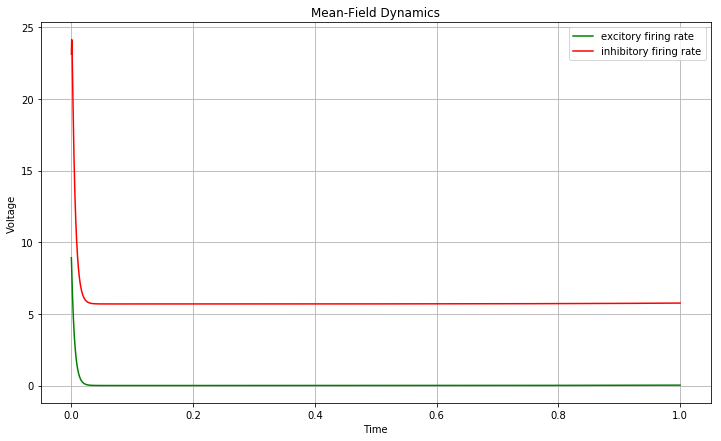

In [112]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace, ve, color="green", label="excitory firing rate")
plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
#plt.plot(t_trace,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Voltage")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,20)
#plt.xlim(0.5,0.75)
plt.show()

In [149]:
from scipy.integrate import odeint
t = np.arange(0, 10, 1e-6)

In [150]:
np.random.seed(20)
#init_state = np.random.rand(7)*1e-5
init_state = np.ones(7)*0.5
init_state[0]=0.5
init_state[1]=17.
init_state[6]=init_state[0]*100e-12
#init_state[3]=init_state[4]
print(init_state)
state2 = odeint(MeanField_Split, init_state, t)

[5.0e-01 1.7e+01 5.0e-01 5.0e-01 5.0e-01 5.0e-01 5.0e-11]


In [53]:
print(state2)
print(t)
X_final=state2[-1]

[[5.00000000e-01 1.70000000e+01 5.00000000e-01 ... 5.00000000e-01
  5.00000000e-01 5.00000000e-11]
 [5.08811563e-01 1.68970686e+01 5.04528173e-01 ... 4.51826139e-01
  1.71639604e+00 5.00000204e-11]
 [5.21520286e-01 1.68051505e+01 5.11672895e-01 ... 3.91869409e-01
  2.74895793e+00 5.00000946e-11]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[0.0000e+00 1.0000e-04 2.0000e-04 ... 4.9997e+00 4.9998e+00 4.9999e+00]


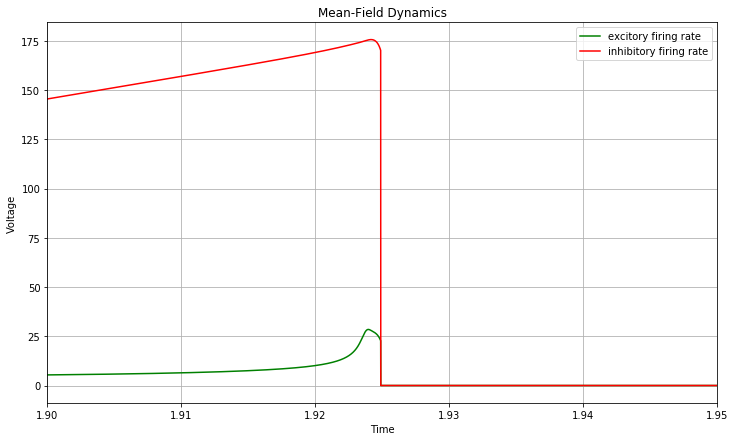

In [155]:
plt.figure(figsize=(12, 7))
plt.plot(t, state2[:, 0], color="green", label="excitory firing rate")
plt.plot(t, state2[:, 1], color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
#plt.plot(t_trace2,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Voltage")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,20)
plt.xlim(1.9,1.95)
plt.show()

In [145]:
print(t[38466])
print(state2[38465])
print(state2[38466])
print(state2[38467])
#test=state2[:][1]
#test2=test[test==max(test)]
test_input[38466]


1.9233
[2.06012515e+01 1.74070478e+02 2.35167871e+02 6.30159416e+01
 6.30159416e+01 6.35998521e+01 2.44932309e-10]
[2.11732371e+01 1.74156371e+02 2.64285014e+02 6.83634531e+01
 6.83634531e+01 6.48606858e+01 2.45018944e-10]
[0. 0. 0. 0. 0. 0. 0.]


89.42025681248161

In [119]:
TF[0](400,400,2.4064069e-10)

196.44444442605695

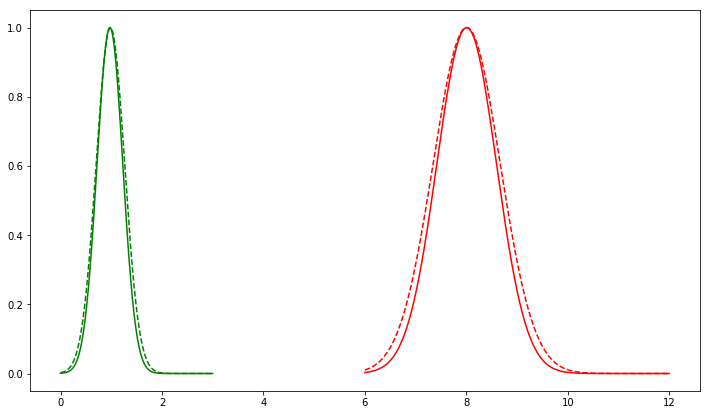

In [136]:

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x0_values = np.linspace(6, 12, 1000)
x1_values = np.linspace(0, 3, 1000)
X_final=state[-1]
X_Matteo=[9.83565096e-01, 8.03686316e+00, 7.90575731e-02, 1.58930985e-01,
       4.38319087e-01, 5.90139017e-11, 4.54486039e-32]

plt.figure(figsize=(12, 7))
plt.plot(x1_values, gaussian(x1_values, X_final[0], np.sqrt(X_final[2])),color="green", label="excitory firing rate")
plt.plot(x0_values, gaussian(x0_values, X_final[1], np.sqrt(X_final[3])),color="red", label="inhibitory firing rate")
plt.plot(x1_values, gaussian(x1_values, X_Matteo[0], np.sqrt(X_Matteo[2])),ls="--",color="green", label="excitory firing rate")
plt.plot(x0_values, gaussian(x0_values, X_final[1], np.sqrt(X_Matteo[4])),ls="--",color="red", label="inhibitory firing rate")
plt.show()

In [31]:
def discrete_deriv_1(funct, ve, vi, w, h):
    #ve, vi = state
    deriv = (funct(ve+0.5*h,vi,w)- funct(ve-0.5*h,vi,w))/h
    return deriv

def discrete_deriv_2(funct, ve, vi, w , h):
    #ve, vi = state
    deriv = (funct(ve,vi+0.5*h,w)- funct(ve,vi-0.5*h,w))/h
    return deriv

def second_deriv_12(funct, ve,vi,w, h):
    deriv2 = (discrete_deriv_1(funct,ve,vi+0.5*h,w,h)-discrete_deriv_1(funct,ve,vi-0.5*h,w,h))/h
    return deriv2

def second_deriv_21(funct, ve,vi,w, h):
    deriv2 = (discrete_deriv_2(funct,ve+0.5*h,vi,w,h)-discrete_deriv_2(funct,ve-0.5*h,vi,w,h))/h
    return deriv2

def second_deriv_11(funct, ve,vi,w, h):
    deriv2 = (discrete_deriv_1(funct,ve+0.5*h,vi,w,h)-discrete_deriv_1(funct,ve-0.5*h,vi,w,h))/h
    return deriv2


def second_deriv_22(funct, ve,vi,w, h):
    deriv2 = (discrete_deriv_2(funct,ve,vi+0.5*h,w,h)-discrete_deriv_2(funct,ve,vi-0.5*h,w,h))/h
    return deriv2




In [108]:
def MeanField_dynamics_manual(state,t):
        
    ve=state[0]
    vi=state[1]
    cee=state[2]
    cii=state[3]
    cei=state[4]
    cie=state[5]
    w=state[6]
    
    deriv=[]
    ve_sec=ve+2.5
    
   
    #print('TF1 before input = ', TF1(ve_sec,vi),'\n')
    #d_ve = params[0]*(-ve + TF1(ve_sec, vi) + 0.5 * (cee*second_deriv_11(TF1,ve_sec,vi,h)+cei*second_deriv_12(TF1,ve_sec,vi,h)+cie*second_deriv_21(TF1,ve_sec,vi,h)+cii*second_deriv_22(TF1,ve_sec,vi,h)))/T
    #print('dve before input = ',d_ve,'\n')
    
    #print('t = ',t,'\n','input_rate =',input_rate(t,0.005,0.0005,0.002,5))
    
    d_ve = (-ve + TF1(ve_sec, vi,w) + 0.5 * (cee*second_deriv_11(TF1,ve_sec,vi,w,h)+cei*second_deriv_12(TF1,ve_sec,vi,w,h)+cie*second_deriv_21(TF1,ve_sec,vi,w,h)+cii*second_deriv_22(TF1,ve_sec,vi,w,h)))/T
    deriv.append(d_ve)
    #print('\n','variables = ',ve_sec,vi,cee,cei,cie,cii,'\n', 'dve = ', d_ve)
    d_vi = (-vi + TF2(ve_sec, vi,0) + 0.5 * (cee*second_deriv_11(TF2,ve_sec,vi,0,h)+cei*second_deriv_12(TF2,ve_sec,vi,0,h)+cie*second_deriv_21(TF2,ve_sec,vi,0,h)+cii*second_deriv_22(TF2,ve_sec,vi,0,h)))/T
    deriv.append(d_vi)
    d_cee = ((TF1(ve_sec,vi,w)*(1/T-TF1(ve_sec,vi,w)))/8000 + (TF1(ve_sec,vi,w)-ve)**2+2*(cee*discrete_deriv_1(TF1,ve_sec,vi,w,h)+cei*discrete_deriv_2(TF1,ve_sec,vi,w,h)) - 2*cee)/T
    deriv.append(d_cee)
    d_cii = ((TF2(ve_sec,vi,w)*(1/T-TF2(ve_sec,vi,0)))/2000+ (TF2(ve_sec,vi,0)-vi)**2+2*(cie*discrete_deriv_1(TF2,ve_sec,vi,0,h)+cii*discrete_deriv_2(TF2,ve_sec,vi,0,h)) - 2*cii)/T
    deriv.append(d_cii)
    d_cei = ((TF1(ve_sec,vi,w)-ve)*(TF2(ve_sec,vi,0)-vi)+cie*discrete_deriv_1(TF1,ve_sec,vi,w,h)+cii*discrete_deriv_2(TF1,ve_sec,vi,w,h)+cee*discrete_deriv_1(TF2,ve_sec,vi,0,h)+cei*discrete_deriv_2(TF2,ve_sec,vi,0,h) - 2*cei)/T
    deriv.append(d_cei)
    d_cie = ((TF1(ve_sec,vi,w)-ve)*(TF2(ve_sec,vi,0)-vi)+cie*discrete_deriv_1(TF1,ve_sec,vi,w,h)+cii*discrete_deriv_2(TF1,ve_sec,vi,w,h)+cee*discrete_deriv_1(TF2,ve_sec,vi,0,h)+cei*discrete_deriv_2(TF2,ve_sec,vi,0,h) - 2*cie)/T
    deriv.append(d_cie)
    dw=-w/1.+60e-12*ve#+a[i]*(mu[i](*vsec_vec,params)-El[i]))
    deriv.append(dw)
    
    return deriv

In [60]:
TF1_test=np.zeros((201,201))
TF2_test=np.zeros((201,201))
w0=100e-12

for ve in np.linspace(0,200,401):
    for vi in np.linspace(0,200,201):    
        
        TF1_test[int(ve)][int(vi)]=TF[0](ve/10,vi/10,w0)
        TF2_test[int(ve)][int(vi)]=TF[1](ve/10,vi/10,w0)
      
################ Here ve on the y axis !!

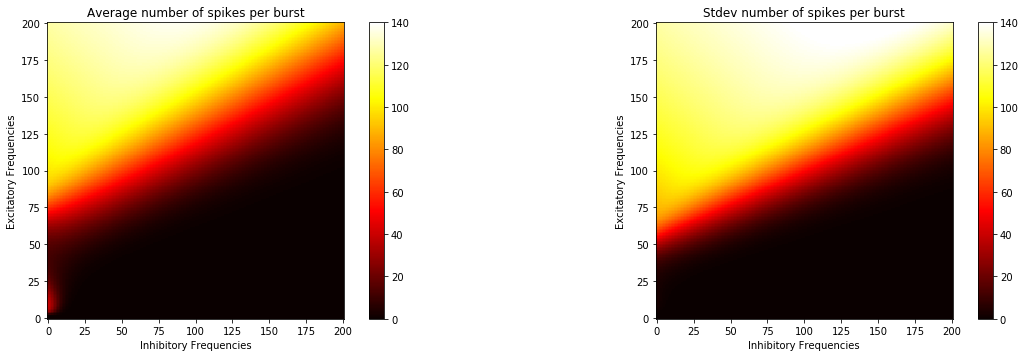

In [22]:
fig2=plt.figure(figsize=(20,12))
ax21=fig2.add_subplot(221)
ax22=fig2.add_subplot(222)



#heatmap = np.array(firingrates_MF_exc).reshape(len(fetrues_list), len(finhibs_list))

im21=ax21.imshow(TF1_test, cmap='hot', interpolation='nearest',vmin=0,vmax=140)
#ax.set_yticklabels(fetrues_list)
ax21.set_ylabel("Excitatory Frequencies")
#ax.set_xticklabels(finhibs_list)
ax21.invert_yaxis()
ax21.set_xlabel("Inhibitory Frequencies")
ax21.set_title("Average number of spikes per burst")
fig2.colorbar(im21, ax=ax21)

im22=ax22.imshow(TF2_test, cmap='hot', interpolation='nearest',vmin=0,vmax=140)
#ax.set_yticklabels(fetrues_list)
ax22.set_ylabel("Excitatory Frequencies")
#ax.set_xticklabels(finhibs_list)
ax22.invert_yaxis()
ax22.set_xlabel("Inhibitory Frequencies")
ax22.set_title("Stdev number of spikes per burst")
fig2.colorbar(im22,ax=ax22)

In [38]:
print(TF1(7.5,2.5,w0),TF2(5.2,2.5,w0))

39.45741167534905 17.299808648383266


10 time units from Matteo's code :

9.83565096e-01, 8.03686316e+00, 7.90575731e-02, 1.58930985e-01,
       4.38319087e-01, 5.90139017e-11, 4.54486039e-32
    
ve,vi,cee,cei,cii,w,?

In [38]:
test_input=[]
for i in t:
   # print(i), print (input_rate(i))
    test_input.append(input_rate(i, 2., 0.1, 0.1, 120, 1))

In [75]:
def MeanField_Opt(x0,t):
    #print(' t = ',t)
    tstep=params[0]
    tot_numb=params[1]
    tauw=params[2]
    a=params[3]
    b=params[4]
    El=params[5]
    N=params[6]
    numb_var=params[7]
    numb_adapt=params[8]
    F=params[9]
    h=params[10]
    T=params[11]
    mu=params[20]
    ext_drive=params[21]
   # vsec_vec=[]

    deriv=np.zeros(tot_numb)
    
    ''' Define vsec_vec, because of the way TF are defined and the different arguments they take 
    (adaptive versus non adaptive populations)'''
    
    vsec_vec=np.zeros((numb_var,numb_var+1))  # Needed to pass different values to TF1 and TF2
    
    for i in range(numb_var):
        for j in range(numb_var):
            vsec_vec[i][j]=x0[j]
    
    for i in range(numb_adapt):
            vsec_vec[i][numb_var]=x0[numb_var*numb_var+numb_var+i]


    
    ''' To optimize the notations, notice that v[i]=x0[i] ; c[i][j]=x0[numb_var*i+j+numb_var] and w[i]=x0[numb_var**2+numb_var+i]'''
                   

    
    for i in range(numb_var):
        vsec_vec[i][0]+=ext_drive#+input_rate(t, 2., 0.1, 0.1, 120, 1) #+input_rate(t,0.1,0.005,0.02,10)
    

    
    # Define the TF derivatives here to compute them only once #
    
    Delta1=np.zeros((numb_var,numb_var))
    Delta2=np.zeros((numb_var,numb_var,numb_var))
    
    Eval_TF=np.zeros(numb_var)
    
    for i in range(numb_var):
        Eval_TF[i]=F[i](*vsec_vec[i])
        #print('evaluated TF',i,' = ', Eval_TF[i])
        for k in range(numb_var):
            Delta1[i][k]=deriv1(F[i],vsec_vec[i],numb_var,h)[k]
            for j in range(numb_var):
                Delta2[i][k][j]=deriv2(F[i],vsec_vec[i],numb_var,h)[k][j]
                #print(Delta2[i][k][j])

    
    for i in range(numb_var):
        deriv[i]=(Eval_TF[i]-x0[i])

        deriv[numb_var*i+i+numb_var]+=(Eval_TF[i]*(1./T-Eval_TF[i])/N[i])
        for j in range(numb_var):
            index=numb_var*i+j+numb_var # define here the location of the considered c variable and its derivative
            for k in range(numb_var): 
                deriv[i]+=(0.5*Delta2[i][j][k]*x0[numb_var*j+k+numb_var])
                
            deriv[index]+=((Eval_TF[i]-x0[i])*(Eval_TF[j]-x0[j])-2*x0[index])
  
            for k in range(numb_var):
                index_ik=numb_var*i+k+numb_var
                index_jk=numb_var*j+k+numb_var
                deriv[index]+=(x0[index_jk]*Delta1[i][k]+x0[index_ik]*Delta1[j][k])
    for i in range(numb_adapt):
        deriv[numb_var**2+numb_var+i]=(-x0[numb_var**2+numb_var+i]/tauw[i]+b[i]*x0[i])#+a[i]*(mu[i](*vsec_vec[i],params)-El[i]))
        
      # DEFINE MU !!!!#
    
    
    ''' Deriv already shaped to plug it into RK4 routine '''
                
    return deriv

In [83]:
t = np.arange(0, 8, 5e-5)

In [84]:
np.random.seed(20)
#init_state = np.random.rand(7)*1e-5
init_state = np.ones(7)*1e-2
init_state[0]=0.5
init_state[1]=17.
init_state[6]=init_state[0]*100e-12
#init_state[3]=init_state[4]
print(init_state)
state3 = odeint(MeanField_Opt, init_state, t)

[5.0e-01 1.7e+01 1.0e-02 1.0e-02 1.0e-02 1.0e-02 5.0e-11]


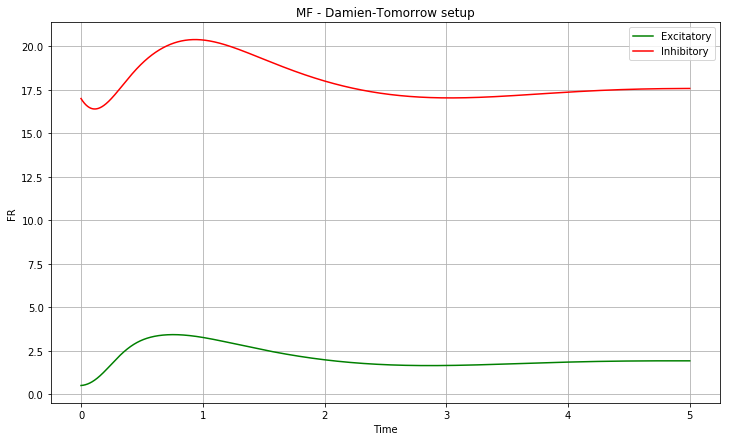

In [82]:
plt.figure(figsize=(12, 7))
plt.plot(t, state3[:, 0], color="green", label="Excitatory")
plt.plot(t, state3[:, 1], color="red", label="Inhibitory")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
#plt.plot(t_trace2,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red"Time_traces_2_b2_50.npy, ls="--")
#plt.plot(t,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("FR")
plt.legend()
plt.title("MF - Damien-Tomorrow setup")
#plt.ylim(0,20)
#plt.xlim(0.5,0.75)
plt.show()

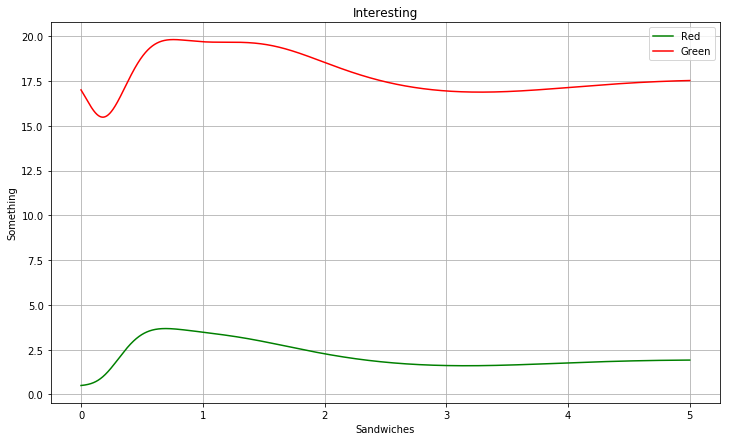

In [65]:
plt.figure(figsize=(12, 7))
plt.plot(t, state3[:, 0], color="green", label="Red")
plt.plot(t, state3[:, 1], color="red", label="Green")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
#plt.plot(t_trace2,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Sandwiches")
plt.grid(True)
plt.ylabel("Something")
plt.legend()
plt.title("Interesting")
#plt.ylim(0,20)
#plt.xlim(0.5,0.75)
plt.show()